# Exploratory Data Analysis (EDA)

In [98]:
import numpy as np
import pandas as pd
from os.path import join
from tqdm import tqdm
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
import matplotlib.pyplot as plt

## 1 Exploring the train.csv metadata file

In [19]:
df = pd.read_csv('./data/train.csv')
df.head()

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


In [20]:
df.describe()

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
count,1.068000e+05,106800.000000,106800.000000,1.068000e+05,106800.000000,106800.000000,1.068000e+05,106800.000000,106800.000000,106800.000000,106800.000000,106800.000000,106800.000000,106800.000000
mean,2.104387e+09,26.286189,118.817228,1.067262e+09,43.733596,520.431404,2.141415e+09,32304.428493,0.878024,1.138783,1.264925,0.948296,1.059185,1.966283
std,1.233371e+09,69.757658,314.557803,6.291475e+08,104.292116,1449.759868,1.241670e+09,18538.196252,1.538873,2.818845,3.131889,2.136799,2.228492,3.621180
min,5.686570e+05,0.000000,0.000000,3.537330e+05,0.000000,0.000000,3.380000e+02,56.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.026896e+09,1.000000,6.000000,5.238626e+08,2.000000,12.000000,1.067419e+09,16707.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.071326e+09,5.000000,26.000000,1.057904e+09,8.000000,62.000000,2.138332e+09,32068.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.172787e+09,16.000000,82.000000,1.623195e+09,29.000000,394.000000,3.217816e+09,48036.000000,1.000000,1.000000,0.000000,1.000000,1.000000,2.000000
max,4.294958e+09,742.000000,3372.000000,2.147388e+09,1021.000000,17632.000000,4.294934e+09,65494.000000,19.000000,18.000000,16.000000,15.000000,15.000000,25.000000


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106800 entries, 0 to 106799
Data columns (total 15 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   eeg_id                            106800 non-null  int64  
 1   eeg_sub_id                        106800 non-null  int64  
 2   eeg_label_offset_seconds          106800 non-null  float64
 3   spectrogram_id                    106800 non-null  int64  
 4   spectrogram_sub_id                106800 non-null  int64  
 5   spectrogram_label_offset_seconds  106800 non-null  float64
 6   label_id                          106800 non-null  int64  
 7   patient_id                        106800 non-null  int64  
 8   expert_consensus                  106800 non-null  object 
 9   seizure_vote                      106800 non-null  int64  
 10  lpd_vote                          106800 non-null  int64  
 11  gpd_vote                          106800 non-null  i

In [22]:
print(f"Number of unique categories in expert_consensus: {df['expert_consensus'].nunique()}")

Number of unique categories in expert_consensus: 6


In [23]:
df['expert_consensus'].value_counts()

expert_consensus
Seizure    20933
GRDA       18861
Other      18808
GPD        16702
LRDA       16640
LPD        14856
Name: count, dtype: int64

<Axes: title={'center': 'Frequency distribution of expert_consensus'}, xlabel='expert_consensus'>

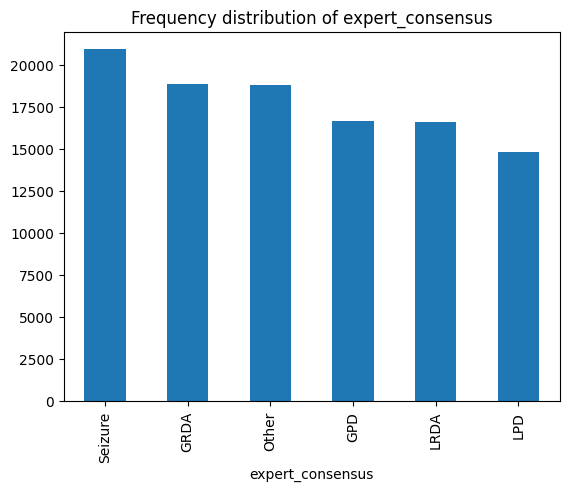

In [24]:
df['expert_consensus'].value_counts().plot(kind='bar', title='Frequency distribution of expert_consensus')

## Observations

### Number of datapoints
There are 106,800 datapoints in the train.csv file with no missing values, which can later be separated into train, validation and test datasets. The 106,800 datapoints seen in train.csv are not the actual EEG or spectrogram data, but rather contains labels (seizure_vote, lpd_vote, gpd_vote, lrda_vote, grda_vote, other_vote) and provides the information (eeg_label_offset_seconds, spectrogram_label_offset_seconds) needed to extract the portions of the raw data (e.g. EEG and spectrograms) that correspond to the labels. Using this information, a dataset with the corresponding EEG, spectrogram data and labels can be generated.

### Labels
In terms of labels, based on the information on maximum and minimum values provided by the .describe() function, it can be seen that they range from 0 to a maximum of 25, hence, doing some normalization on the labels might potentially improve training. Taking a look at the bar plot of the frequency distribution of the categorical feature 'expert_consensus', it can be seen that the distribution of datapoints within each category is not particularly skewed in any direction although not evenly distributed, which may be alright to use for training, validation and testing without modification, but removing some datapoints to ensure an even distribution across categories may prove useful.

## 2 Generating dataset using train.csv and raw data

In [110]:
class HMS_Dataset(Dataset):

    def __init__(self, root_path : str = "./data/") -> None:
        super(HMS_Dataset, self).__init__()
        self.data_root = root_path
        self.train_list = pd.read_csv(join(root_path, "train.csv"))
        self.eeg_sample_freq = 200
        self.spec_sample_freq = 0.5

    def __getitem__(self, index) -> dict:
        row = self.train_list.iloc[index]

        eeg_id = row["eeg_id"]
        eeg_sub_id = row["eeg_sub_id"]
        eeg_label_offset_seconds = row["eeg_label_offset_seconds"]
        spec_id = row["spectrogram_id"]
        spec_sub_id = row["spectrogram_sub_id"]
        spec_label_offset_seconds = row["spectrogram_label_offset_seconds"]
        label_id = row["label_id"]
        patient_id = row["patient_id"]
        expert_consensus = row["expert_consensus"]
        seizure_vote = row["seizure_vote"]
        lpd_vote = row["lpd_vote"]
        gpd_vote = row["gpd_vote"]
        lrda_vote = row["lrda_vote"]
        grda_vote = row["grda_vote"]
        other_vote = row["other_vote"]

        # Read eeg and spectrogram raw data
        eeg = pd.read_parquet(join("./data/train_eegs/", str(eeg_id)+".parquet"))
        spec = pd.read_parquet(join("./data/train_spectrograms/", str(spec_id)+".parquet"))

        # EEG sub-sampling
        start = int(eeg_label_offset_seconds*self.eeg_sample_freq)
        end = int((eeg_label_offset_seconds+50)*self.eeg_sample_freq)
        eeg = eeg.iloc[start:end]
        eeg = np.array(eeg)

        # Spectrogram sub-sampling
        start = int(spec_label_offset_seconds*self.spec_sample_freq)
        end = int((spec_label_offset_seconds+600)*self.spec_sample_freq)
        spec = spec.iloc[start:end].drop(columns=['time'])
        spec = np.array(spec)
        spec = np.expand_dims(spec, axis=0)

        # Labels
        label = np.array([seizure_vote, lpd_vote, gpd_vote, lrda_vote, grda_vote, other_vote])

        return eeg, spec, label

    def __len__(self):
        return self.train_list.shape[0]

In [111]:
data_set = HMS_Dataset()
training_generator = DataLoader(data_set, batch_size=8, shuffle=True, num_workers=6)

## 3 Sample EEGs

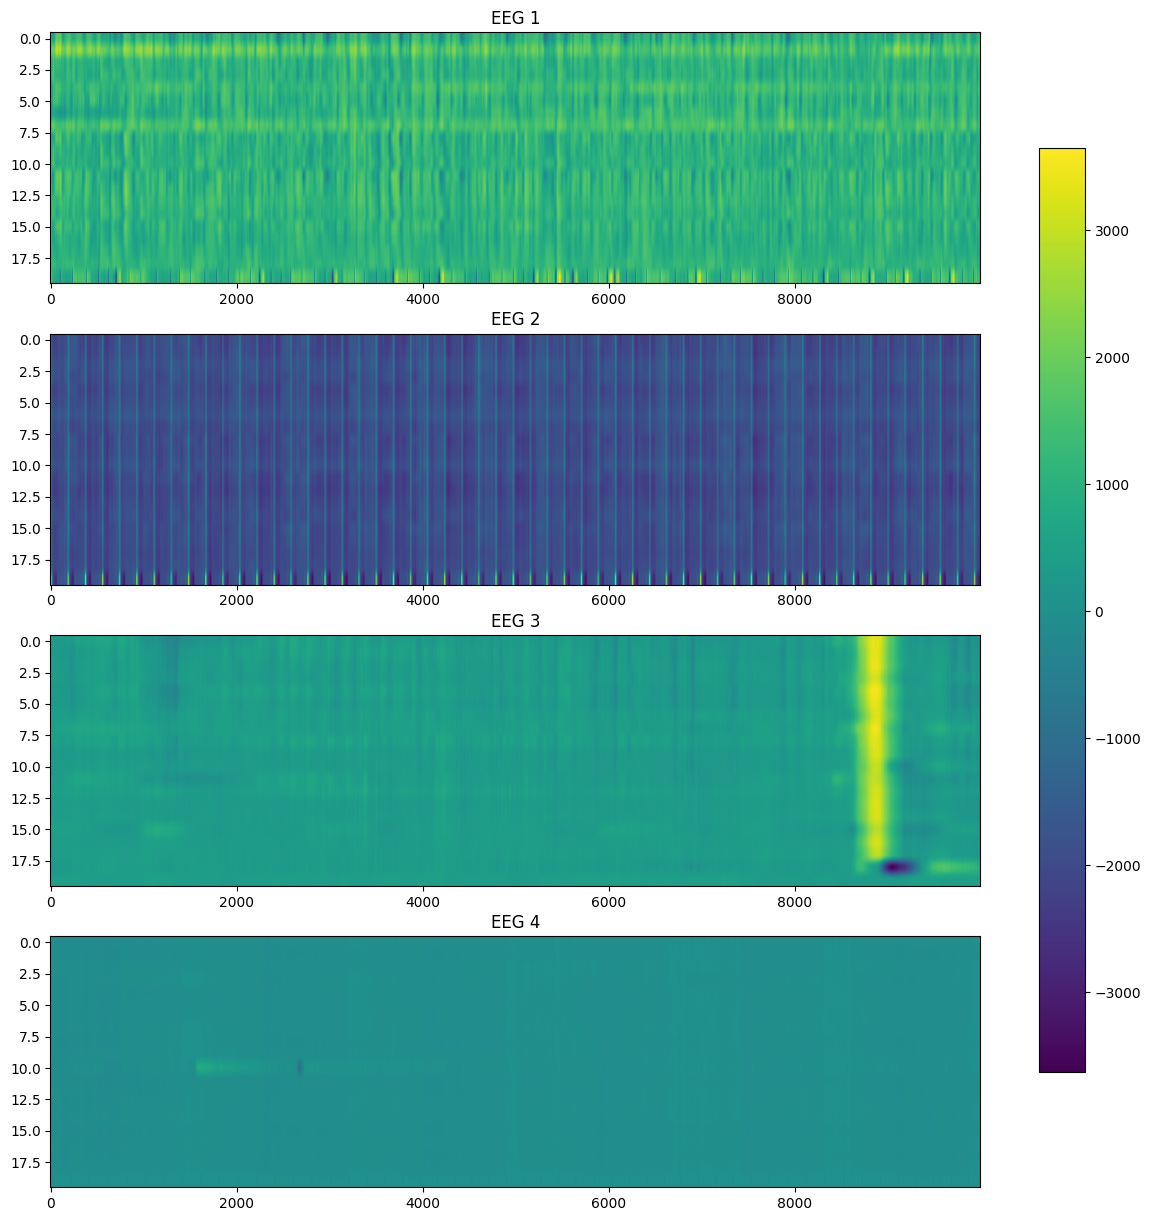

In [166]:
eegs = next(iter(training_generator))[0]

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15, 15))

for i in range(4):
    ax = axes[i]
    im = ax.imshow(eegs[i].T, aspect='auto')
    ax.set_title(f'EEG {i+1}')

fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8)
plt.show()

## 4 Sample spectrograms

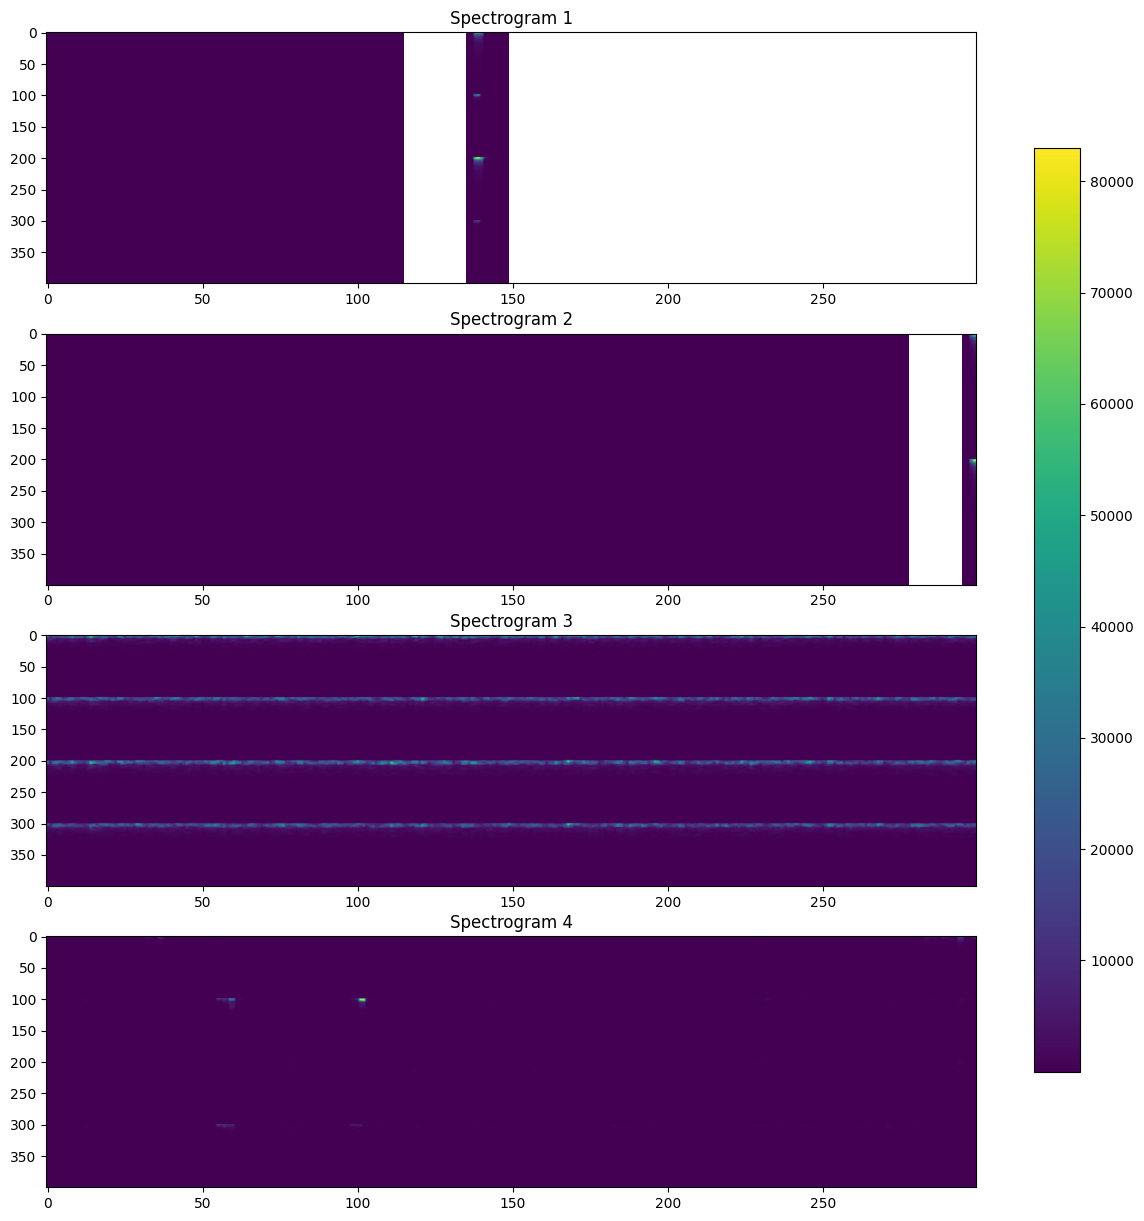

In [167]:
specs = next(iter(training_generator))[1]

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15, 15))

for i in range(4):
    ax = axes[i]
    im = ax.imshow(specs[i].T, aspect='auto')
    ax.set_title(f'Spectrogram {i+1}')

fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8)
plt.show()

As seen in sample plots for EEGs and spectrograms, there are missing values present as shown by the white/empty portions of the plots. Hence, analysis of the NaN values present in the data is important and should be dealth with. In addition to that, the range of values present in the data varies a lot, for example, for the EEG plots, the values go from under -3000 to over 3000, which is not ideal for training, aka should be normalized. Similarly, the spectrogram data also contains values of a large range, from under 10,000 to over 80,000 and should also be normlaized before subsequent steps.

## 5 Summary
Through the exploratory data analysis conducted above, a good understanding of the dataset at hand can be formed, and the following recommendations can be implemented for the next step of data pre-processing before the data is used for training, testing or evaluation to ensure reliable results:

- Normalization of labels
- Normalization of EEG, spectrogram data
- Dropping datapoints for even distribution of datapoints amongs labels (preventing class imbalance)
- Removal of completely empty spectrograms (whole spectrogram is NaN)
- Removal of NaN values within EEG and spectrogram data

Other notes for data pre-processing which may improve performance:
- Experimentation with various normalization schemes
- Experimentation with signal processing techniques (e.g. bandpass filters) could possibly 'clean' noisy signals